# Tutorial on photometry data from the SDSS survey

This tutorial queries the SDSS data base for galaxies, downloads a table with basic photometric properties of the galaxies and makes plots with the downloaded data

This tutorial is based on this tutorial: https://escip.io/notebooks/sdss_tutorial_1.html and also on this tutorial: https://escip.io/notebooks/star_formation_v3.html 


## Objectives

To demonstrate ways of querying and visualizing data from the SDSS, using Python and SQL

In [1]:
import matplotlib
from matplotlib import pylab as plt
# accessing data from SkyView
from astroquery.skyview import SkyView
# standard astronomy packages
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy import coordinates as coords
from astropy.wcs import WCS

import pandas as pd # data analysis 
import numpy as np # more data analysis
import seaborn as sns # plotting library
from astroquery.sdss import SDSS

# for 3 colour images
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import get_pkg_data_filename

# Python standard-libraries to download data from the web
from urllib.parse import urlencode
from urllib.request import urlretrieve

from matplotlib.image import imread

In [2]:
# Make notebook have a clean appearance

pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')

## Obtaining data from SDSS 

We are using and SQL query to get data from the SDSS data base. In this case, we are getting photometry data (magnitudes and galaxy sizes).

In short, every SQL command consists of three blocks:

- The SELECT block: it defines the quantities that you want your query to return.
- The FROM block: it defines which tables of the database you want SQL to look in.
- The WHERE block: it defines any constraints on the data that you want to impose.

<b>Petrosian magnitude: </b>
Stored as petroMag. For galaxy photometry, measuring flux is more difficult than for stars, because galaxies do not all have the same radial surface brightness profile, and have no sharp edges. In order to avoid biases, we wish to measure a constant fraction of the total light, independent of the position and distance of the object. To satisfy these requirements, the SDSS has adopted a modified form of the Petrosian (1976) system, measuring galaxy fluxes within a circular aperture whose radius is defined by the shape of the azimuthally averaged light profile.

https://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp?key=mag_petro 

In [3]:
# SQL query

query = 'SELECT TOP 5000 p.objId, p.ra, p.dec, p.petror90_r, p.g, p.r, p.err_g, p.err_r, p.petroMag_g, p.petroMag_r, p.petroMagErr_r, p.petroMagErr_g ' # defining which measurments we want
query += 'FROM galaxy AS p ' # selecting the data table
query += 'WHERE p.u BETWEEN 0 AND 19.6'
query += 'AND p.g BETWEEN 0 AND 17  AND p.petror90_r > 10 AND p.petror90_r < 40'
#print (query) # useful for debugging, remove first # to uncomment

# send query to SDSS
gals = SDSS.query_sql(query, data_release=16)

gals


objId,ra,dec,petror90_r,g,r,err_g,err_r,petroMag_g,petroMag_r,petroMagErr_r,petroMagErr_g
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1237648675604987911,241.758465781446,1.10539195830498,14.1713,15.28709,14.29342,0.00253945,0.002113927,15.44247,14.45616,0.01843804,0.02270781
1237648704070025320,251.447335294731,-0.235449567118369,20.22132,16.02892,14.94807,0.004190572,0.002790975,16.13263,15.07888,0.009884841,0.01208971
1237648704070156627,251.841189048486,-0.202854609544485,16.69693,15.20077,13.84778,0.008436901,0.004110175,14.36238,13.02569,0.05124776,0.1300085
1237651249919099466,265.38347213949,17.3891358022255,13.04439,15.75299,15.14318,0.003802914,0.003863613,15.32181,14.32245,0.6160502,0.461555
1237651250454070173,263.793796626998,21.4834493949729,11.53161,16.88238,16.58331,0.004948931,0.005338616,16.90803,16.59394,0.02227232,0.01312742
1237651250457543653,267.62053642145,14.3943813942417,15.38324,14.58169,13.72256,0.002374631,0.002340077,14.54344,13.68518,0.01193452,0.01098615
1237651250993234765,266.702792117165,16.9690122570821,12.25322,16.49914,16.01818,0.008930697,0.008716553,12.65001,14.05173,0.4345905,0.004334079
1237651252061536549,261.409293201519,28.4238082557385,10.52122,9.452971,8.262579,0.000349405,0.0003797987,9.397386,8.252803,0.0001733484,0.0001852973
1237651252063764605,264.014430873188,23.9997600109154,16.04928,16.66008,15.73234,0.0234215,0.004817179,16.59203,15.75701,0.9191263,1.269255


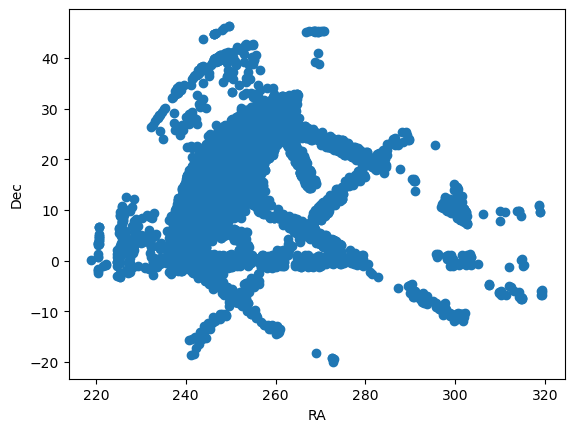

In [4]:
plt.scatter(gals['ra'], gals['dec'])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()


# What do you see? 

The oval shape and the stripes represent the footprint of the SDSS survey, e.g. the parts of the sky that can have been observed during the imaging survey.

This mostely depends on which part of the sky is visible from New Mexico, where the telescope is. 

In [5]:
gals.keys()

['objId',
 'ra',
 'dec',
 'petror90_r',
 'g',
 'r',
 'err_g',
 'err_r',
 'petroMag_g',
 'petroMag_r',
 'petroMagErr_r',
 'petroMagErr_g']

# Colour - magnitude diagram

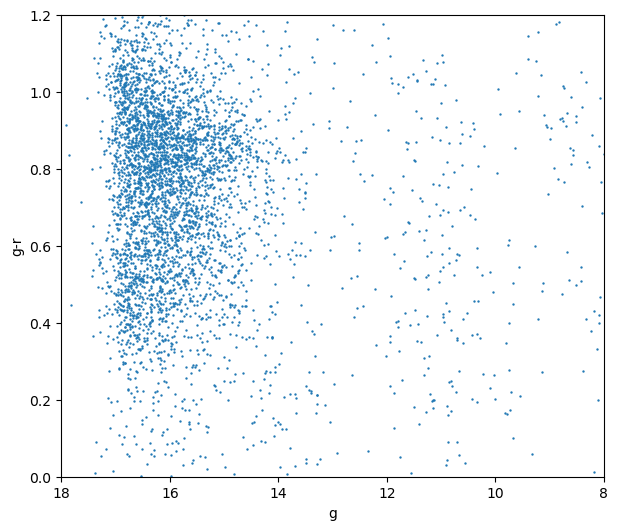

In [6]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
plt.scatter(gals['petroMag_g'], gals['petroMag_g']-gals['petroMag_r'], s=0.5)
plt.xlabel('g')
plt.ylabel('g-r')
ax.set_xlim(8, 18)
ax.set_ylim(0, 1.2)
ax.invert_xaxis()
plt.show()

# What do you see in the plot?

Note that most of the points are between 14 < g magnitude < 17. In addition to this, there are many scattered points at g magnitude < 14. These are susupiciously bright data points that are most likely not galaxies. Very bright objects could be stars or imaging problems. 

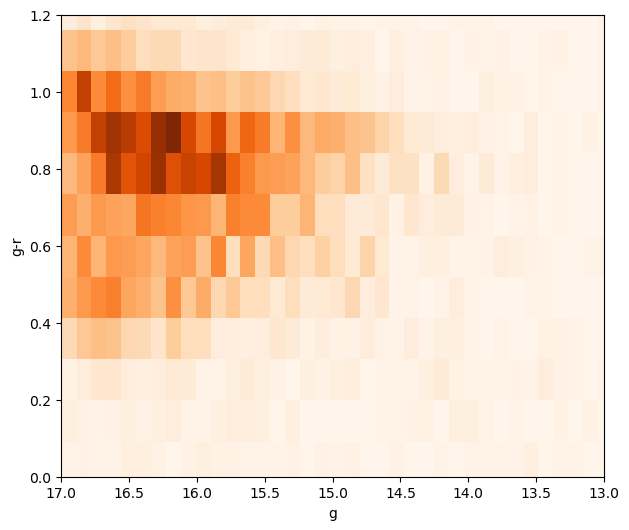

In [7]:
gals['g-r']=gals['petroMag_g']-gals['petroMag_r']

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
counts,xbins,ybins,image = plt.hist2d(gals['petroMag_g'], gals['petroMag_g']-gals['petroMag_r'],bins=300, cmap='Oranges')
#plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=2, cmap = "Oranges")
plt.xlabel('g')
plt.ylabel('g-r')
ax.set_xlim(13, 17)
ax.set_ylim(0, 1.2)
ax.invert_xaxis()
plt.show()



## Searching for "small" red galaxies

First lets identify a way of selecting red and "small" galaxies and red galaxies.


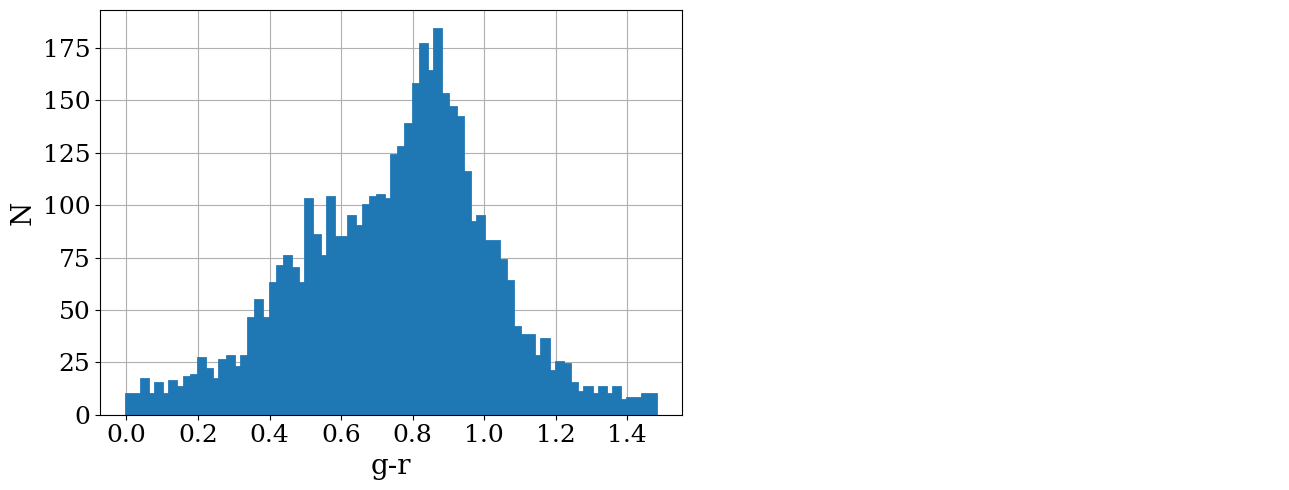

In [8]:
fig = plt.figure(figsize=(13.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(1,2,1)
d =  gals['petroMag_g']-gals['petroMag_r']
bin_size = np.arange(0,1.5,0.02) 
plt.hist(d, bins=bin_size, histtype='step', color='C0', fill=True, linewidth=2)
#plt.axvline(1/317.83, color='C1', lw=4, label='Earth')
plt.xticks(family='serif',size=18)
plt.yticks(family='serif',size=18)
ax1.set_xlabel('g-r', size=20,family='serif')
ax1.set_ylabel('N', size=20,family='serif')
plt.grid(True)
#plt.legend()
#plt.xlim(0.00,13)
plt.tight_layout()

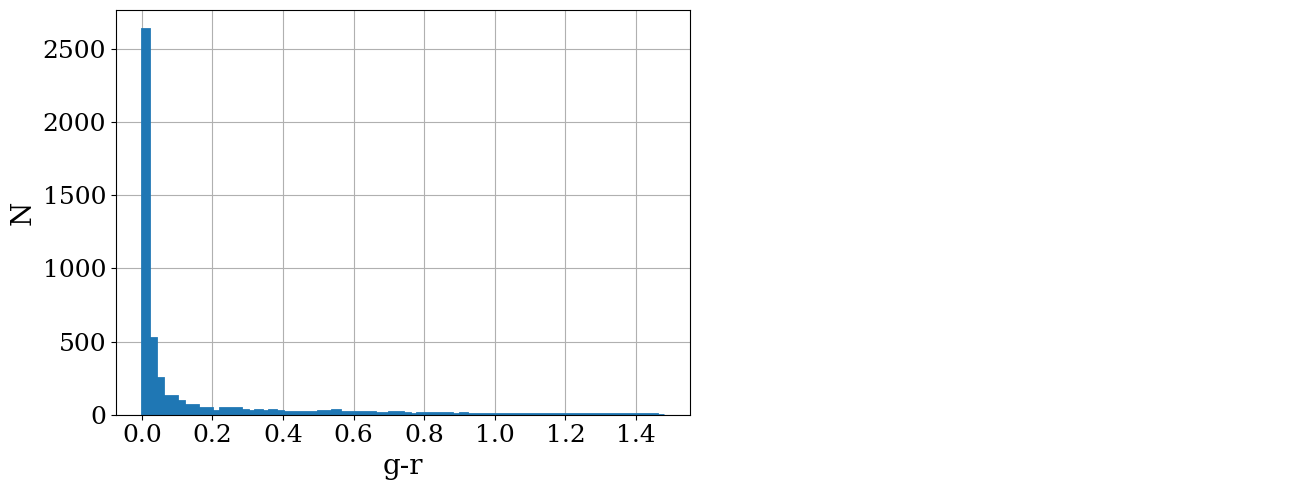

In [9]:
fig = plt.figure(figsize=(13.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(1,2,1)
d =  gals['petroMagErr_r']
bin_size = np.arange(0,1.5,0.02) 
plt.hist(d, bins=bin_size, histtype='step', color='C0', fill=True, linewidth=2)
#plt.axvline(1/317.83, color='C1', lw=4, label='Earth')
plt.xticks(family='serif',size=18)
plt.yticks(family='serif',size=18)
ax1.set_xlabel('g-r', size=20,family='serif')
ax1.set_ylabel('N', size=20,family='serif')
plt.grid(True)
#plt.legend()
#plt.xlim(0.00,13)
plt.tight_layout()

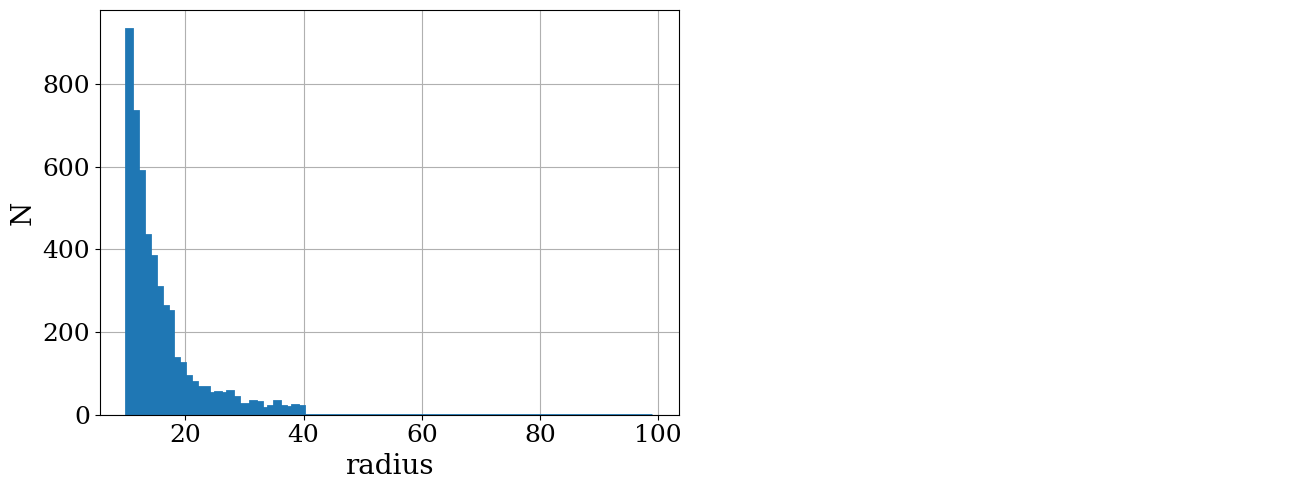

In [10]:
fig = plt.figure(figsize=(13.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(1,2,1)
d =  gals['petror90_r']
bin_size = np.arange(10,100,1) 
plt.hist(d, bins=bin_size, histtype='step', color='C0', fill=True, linewidth=2)
#plt.axvline(1/317.83, color='C1', lw=4, label='Earth')
plt.xticks(family='serif',size=18)
plt.yticks(family='serif',size=18)
ax1.set_xlabel('radius', size=20,family='serif')
ax1.set_ylabel('N', size=20,family='serif')
plt.grid(True)
#plt.legend()
#plt.xlim(0.00,13)
plt.tight_layout()

In [18]:
#print(gals)

In [17]:
#gals['g-r'] = gals['g']-gals['r']

#gals
#print(gals)

In [19]:
gals['g-r'] = gals['g']-gals['r']

#gals
print(len(gals))

# quality cuts, these are important to make sure that we only have galaxies in the sample
gals = gals[gals['petroMagErr_r'] < 0.05]
gals = gals[gals['petroMagErr_g'] < 0.05]
gals = gals[gals['g'] > 13]

print(len(gals))

5000
2704


In [20]:
red = gals[gals['g-r'] > 1]
red_2 = red[red['g-r'] < 1.1]

In [32]:
#print(red)
#red

In [22]:
small_red = red_2[red_2['petror90_r'] < 15]

In [39]:
#print(len(small_red))
#small_red

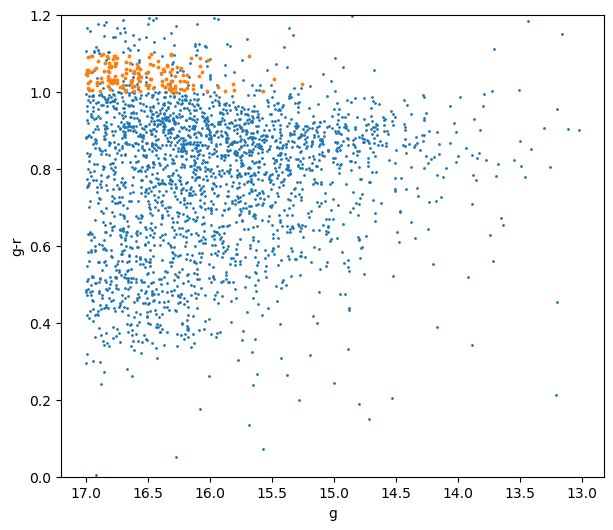

In [29]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
plt.scatter(gals['g'], gals['g']-gals['r'], s = 1)
plt.scatter(small_red['g'], small_red['g']-small_red['r'], s =3)
plt.xlabel('g')
plt.ylabel('g-r')
ax.set_ylim(0, 1.2)
ax.invert_xaxis()
plt.show()

## Lets get an image for one of our small red galaxies

We are going to use SkyView for this, since we know how it works

In [36]:
c = SkyCoord(ra=small_red['ra'][0]*u.degree, dec=small_red['dec'][0]*u.degree, frame='icrs')
print(c.ra.hms, c.dec)

path = SkyView.get_images(position=c, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSr'], pixels=[300,300])

hdulist_DSS2 = path[0]
d_DSS2 = hdulist_DSS2[0].data
h_DSS2 = hdulist_DSS2[0].header

hms_tuple(h=16.0, m=0.0, s=38.10720984601801) -1d06m42.84186348s


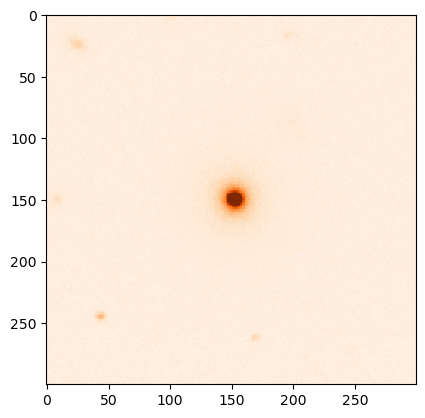

In [37]:
plt.imshow(d_DSS2, cmap='Oranges', vmax=np.percentile(d_DSS2, 99.9))

# Getting images from the SDSS cutout server

The next section directly downloads 3 coulor composit images from the SDSS Image Cutout service. 

In [38]:
#
# Function to display images
#
def get_images(gal_array,description):
    # set thumbnail parameters
    width=200           # image width
    height=200          # height
    pixelsize=0.396     # image scale
    plt.figure(figsize=(15, 15))   # display in a 4x4 grid
    subPlotNum = 1

    i = 0
    new_gals = gal_array
    nGalaxies = len(new_gals)
    for index in range(0,nGalaxies):           # iterate through rows in the DataFrame
        i = i + 1
        if i<17:
            print('Getting image of '+description+str(i)+' of '+str(nGalaxies)+'...')
            if (i == nGalaxies):
                print('Plotting images...')
            scale=2.0*new_gals['petror90_r']/pixelsize/width
            
            pos = coords.SkyCoord(new_gals['ra'][index], new_gals['dec'][index], unit=u.deg, frame='icrs')
            
            cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
            query_string = urlencode(dict(ra=new_gals['ra'][index], dec=new_gals['dec'][index],width=width, height=height, scale=scale[i]))
            url = cutoutbaseurl + '?' + query_string

            # this downloads the image
            image_name = 'cutout_'+str(index)+'.jpg'
            urlretrieve(url, image_name)

            # Display the image
            img = imread(image_name)

            plt.subplot(4,4,subPlotNum)
            subPlotNum += 1
            plt.imshow(img)                               # show images in grid
            plt.title(index)                              # show the object identifier (objId) above the image.

######


# The Red galaxies

## What do you notice?

Getting image of high SFR galaxy 1 of 160...
Getting image of high SFR galaxy 2 of 160...
Getting image of high SFR galaxy 3 of 160...
Getting image of high SFR galaxy 4 of 160...
Getting image of high SFR galaxy 5 of 160...
Getting image of high SFR galaxy 6 of 160...
Getting image of high SFR galaxy 7 of 160...
Getting image of high SFR galaxy 8 of 160...
Getting image of high SFR galaxy 9 of 160...
Getting image of high SFR galaxy 10 of 160...
Getting image of high SFR galaxy 11 of 160...
Getting image of high SFR galaxy 12 of 160...
Getting image of high SFR galaxy 13 of 160...
Getting image of high SFR galaxy 14 of 160...
Getting image of high SFR galaxy 15 of 160...
Getting image of high SFR galaxy 16 of 160...


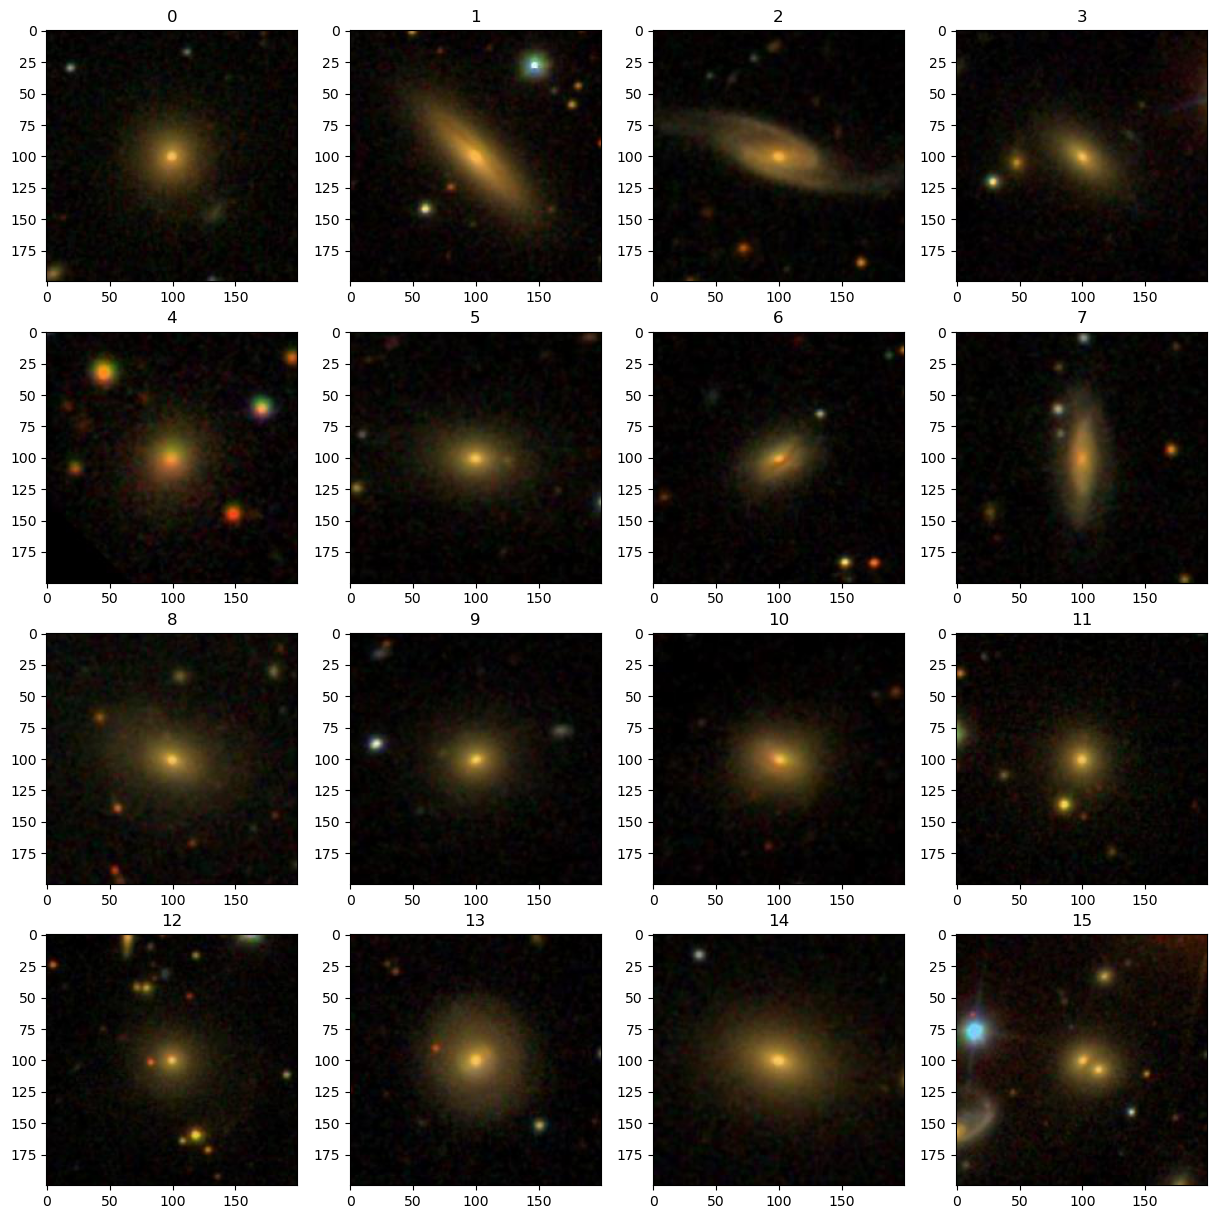

In [39]:
get_images(small_red,'high SFR galaxy ') # call function with filtered galaxy array

# The Blue galaxies

## What do you notice?

In [40]:
blue = gals[gals['g-r'] < 0.7]
blue_2 = blue[blue['g-r'] > 0.4]

small_blue = blue_2[blue_2['petror90_r'] < 20]


In [41]:
print(len(small_blue))

606


Getting image of high SFR galaxy 1 of 606...
Getting image of high SFR galaxy 2 of 606...
Getting image of high SFR galaxy 3 of 606...
Getting image of high SFR galaxy 4 of 606...
Getting image of high SFR galaxy 5 of 606...
Getting image of high SFR galaxy 6 of 606...
Getting image of high SFR galaxy 7 of 606...
Getting image of high SFR galaxy 8 of 606...
Getting image of high SFR galaxy 9 of 606...
Getting image of high SFR galaxy 10 of 606...
Getting image of high SFR galaxy 11 of 606...
Getting image of high SFR galaxy 12 of 606...
Getting image of high SFR galaxy 13 of 606...
Getting image of high SFR galaxy 14 of 606...
Getting image of high SFR galaxy 15 of 606...
Getting image of high SFR galaxy 16 of 606...


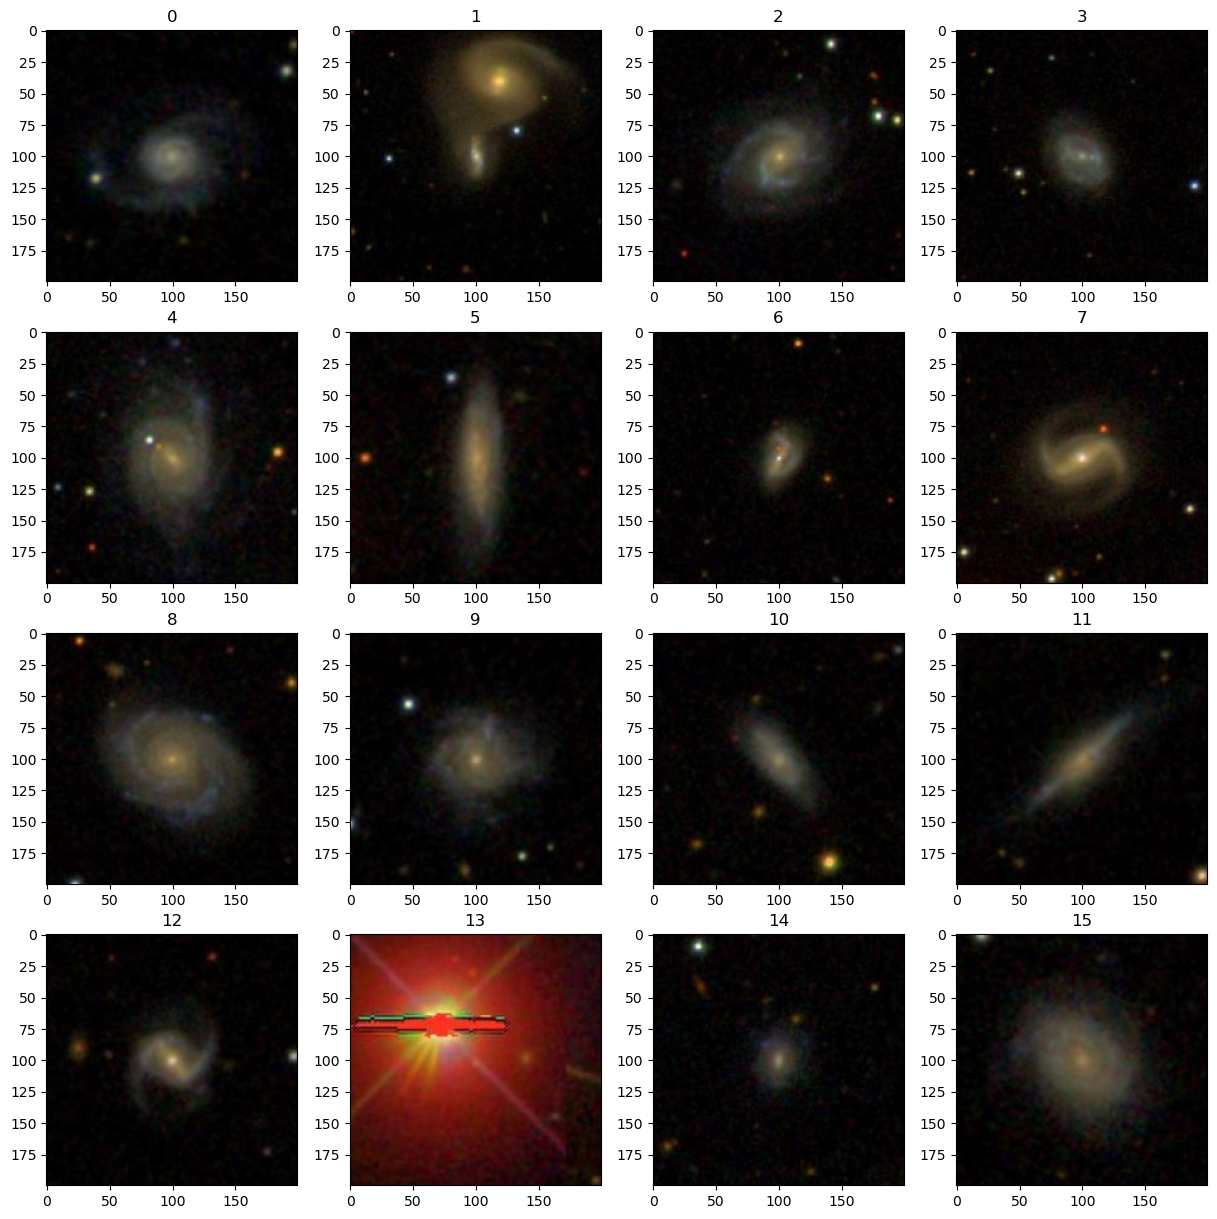

In [42]:
get_images(small_blue,'high SFR galaxy ') # call function with filtered galaxy array

## 3 coulour images using SkyView

This will help us evaluate what type of galaxy we have.


In [43]:
path = SkyView.get_images(position=c, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSg'], pixels=[900,900])

# this line puts the data into a fits image
hdulist_SDSS_g = path[0]
d_SDSS_g = hdulist_SDSS_g[0].data
h_SDSS_g = hdulist_SDSS_g[0].header

path = SkyView.get_images(position=c, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSr'], pixels=[900,900])

# this line puts the data into a fits image
hdulist_SDSS_r = path[0]
d_SDSS_r = hdulist_SDSS_r[0].data
h_SDSS_r = hdulist_SDSS_r[0].header

path = SkyView.get_images(position=c, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSi'], pixels=[900,900])

# this line puts the data into a fits image
hdulist_SDSS_i = path[0]
d_SDSS_i = hdulist_SDSS_i[0].data
h_SDSS_i = hdulist_SDSS_i[0].header

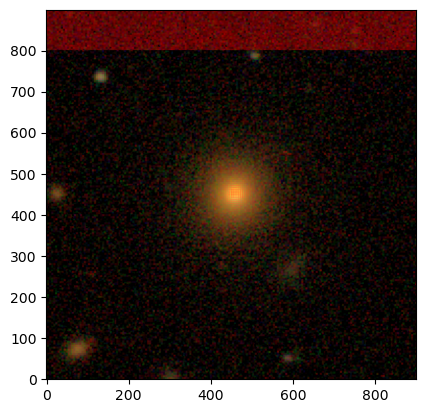

In [44]:
# assigning colours to the image layers
g = d_SDSS_g
r = d_SDSS_r
i = d_SDSS_i

# making a quick image
# A lower Q and stretch parameter make the fainter features in the image visible
rgb_default = make_lupton_rgb(i, r, g, Q=8, stretch=0.5, filename="test.jpeg")

# checking the data
plt.imshow(rgb_default, origin='lower')

### What type of galaxy is this?

## Lets look at some blue galaxies

In [45]:
c_blue = SkyCoord(ra=small_blue['ra'][3]*u.degree, dec=small_blue['dec'][3]*u.degree, frame='icrs')


In [46]:
path = SkyView.get_images(position=c_blue, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSg'], pixels=[300,300])

# this line puts the data into a fits image
hdulist_SDSS_g = path[0]
d_SDSS_g = hdulist_SDSS_g[0].data
h_SDSS_g = hdulist_SDSS_g[0].header

path = SkyView.get_images(position=c_blue, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSr'], pixels=[300,300])

# this line puts the data into a fits image
hdulist_SDSS_r = path[0]
d_SDSS_r = hdulist_SDSS_r[0].data
h_SDSS_r = hdulist_SDSS_r[0].header

path = SkyView.get_images(position=c_blue, width=0.02*u.deg, height=0.02*u.deg, survey=['SDSSi'], pixels=[300,300])

# this line puts the data into a fits image
hdulist_SDSS_i = path[0]
d_SDSS_i = hdulist_SDSS_i[0].data
h_SDSS_i = hdulist_SDSS_i[0].header

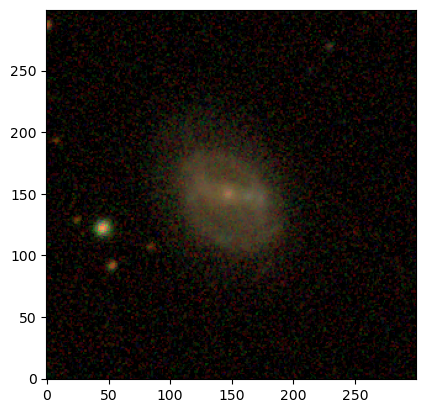

In [47]:
# assigning colours to the image layers
g = d_SDSS_g
r = d_SDSS_r
i = d_SDSS_i

# making a quick image
# A lower Q and stretch parameter make the fainter features in the image visible
rgb_default = make_lupton_rgb(i, r, g, Q=10, stretch=0.5, filename="test.jpeg")

# checking the data
plt.imshow(rgb_default, origin='lower')

### What type of galaxy is this?
